# Dataset

## Original Format

### Load Data

In [1]:
import os
import pathlib
import json
import numpy as np
from PIL import Image, ImageDraw as Drawer
import matplotlib.pyplot as plt
import cv2
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_train_loader, build_detection_test_loader
from detectron2.structures import BoxMode
from detectron2.utils.visualizer import Visualizer
from detectron2.config import get_cfg
from detectron2.modeling import build_model
from detectron2 import model_zoo
from detectron2.data import detection_utils as utils
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import RotatedCOCOEvaluator, DatasetEvaluators, inference_on_dataset
from detectron2.structures import pairwise_iou_rotated, pairwise_iou
import torch
import random
import pandas as pd
from sklearn.metrics import auc

# path to the satcen dataset
satcen_path = pathlib.Path('../satcen_dataset/full').resolve()

In [2]:
# load the full Satcen dataset
satcen = os.listdir(satcen_path/'pictures')

# load the labels (bounding boxes)
labels_file = open(satcen_path/'labels.json')
labels_json = json.load(labels_file)

# define a helper function that returns the list of bounding boxes given a filename
def get_bounding_boxes(filename):
    return list(filter(lambda x: x['name'] == filename, labels_json))[0]['bounding_boxes']

# convert the bounding boxes into binary labels 0/1
y = np.array([])
for img in satcen:

    bounding_boxes = get_bounding_boxes(img)
    y = np.append(y, 1 if len(bounding_boxes) > 0 else 0)

# print info about entire dataset
print(f'Total number of Satcen images: {len(satcen)}')
print(f'Total number of labels (annotations): {len(labels_json)}')
print(f'Number of positive observations: {np.sum(y==1)} ({100 * np.sum(y==1) / len(y):.2f}%)')
print(f'Number of negative observations: {np.sum(y==0)} ({100 * np.sum(y==0) / len(y):.2f}%)\n')

# load the data
train_images = os.listdir(satcen_path/'splits/train/images')
valid_images = os.listdir(satcen_path/'splits/validation/images')
test_images = os.listdir(satcen_path/'splits/test/images')

# compute binary labels for each set
y_train = np.array([y[satcen.index(img)] for img in train_images])
y_valid = np.array([y[satcen.index(img)] for img in valid_images])
y_test = np.array([y[satcen.index(img)] for img in test_images])

# print stats about the splits
print('Train dataset')
print(f'Size: {len(train_images)} ({100 * len(train_images) / len(satcen):.2f}%)')
print(f'Positive observations: {np.sum(y_train==1)} ({100 * np.sum(y_train==1) / len(y_train):.2f}%)')
print(f'Negative observations: {np.sum(y_train==0)} ({100 * np.sum(y_train==0) / len(y_train):.2f}%)')

print('\nValidation dataset')
print(f'Size: {len(valid_images)} ({100 * len(valid_images) / len(satcen):.2f}%)')
print(f'Positive observations: {np.sum(y_valid==1)} ({100 * np.sum(y_valid==1) / len(y_valid):.2f}%)')
print(f'Negative observations: {np.sum(y_valid==0)} ({100 * np.sum(y_valid==0) / len(y_valid):.2f}%)')

print('\nTest dataset')
print(f'Size: {len(test_images)} ({100 * len(test_images) / len(satcen):.2f}%)')
print(f'Positive observations: {np.sum(y_test==1)} ({100 * np.sum(y_test==1) / len(y_test):.2f}%)')
print(f'Negative observations: {np.sum(y_test==0)} ({100 * np.sum(y_test==0) / len(y_test):.2f}%)')

Total number of Satcen images: 9420
Total number of labels (annotations): 9420
Number of positive observations: 1525 (16.19%)
Number of negative observations: 7895 (83.81%)

Train dataset
Size: 5652 (60.00%)
Positive observations: 915 (16.19%)
Negative observations: 4737 (83.81%)

Validation dataset
Size: 1884 (20.00%)
Positive observations: 305 (16.19%)
Negative observations: 1579 (83.81%)

Test dataset
Size: 1884 (20.00%)
Positive observations: 305 (16.19%)
Negative observations: 1579 (83.81%)


## Detectron2 Dataset

### Register Datasets

Register **train** and **validation** datasets based on the existing split.

In [3]:
# ds_type can take two possible values: train and valid
def dataset_function(ds_type):

    # determine which dataset to create
    images = []
    if ds_type == 'train':
        images = train_images
    elif ds_type == 'valid':
        images = valid_images
    else:
        raise f'Invalid value for ds_type: {ds_type}'

    # represents the list of dicts
    dataset = []

    # loop through all images
    for i, image in enumerate(images):
        
        # list of annotations for the current image
        annotations = []

        # get the bounding boxes of the image
        bounding_boxes = get_bounding_boxes(image)

        # loop through the bounding boxes
        for bb in bounding_boxes:
            
            # convert coordinates to required format
            points = np.array([[p['x'], p['y']] for p in bb])

            # get rotated rectangle
            ((cx, cy), (w, h), a) = cv2.minAreaRect(points)

            # store the annotation
            annotations.append({
                'bbox_mode': BoxMode.XYWHA_ABS,
                'bbox': (cx, cy, w, h, -a),
                'category_id': 0 # skiff
            })
        
        # store the image in the dataset
        dataset.append({
            'file_name': satcen_path/'pictures'/image,
            'height': 256,
            'width': 256,
            'image_id': i,
            'annotations': annotations
        })

    return dataset

# register training dataset
if 'satcen_train' in DatasetCatalog.keys():
    DatasetCatalog.remove('satcen_train')
DatasetCatalog.register('satcen_train', lambda x='train': dataset_function(x))

# register validation dataset
if 'satcen_valid' in DatasetCatalog.keys():
    DatasetCatalog.remove('satcen_valid')
DatasetCatalog.register('satcen_valid', lambda x='valid': dataset_function(x))

# set metadata for the datasets
MetadataCatalog.get('satcen_train').thing_classes = ['skiff']
MetadataCatalog.get('satcen_valid').thing_classes = ['skiff']

### Show Examples

Show examples of the images from the original dataset and from the Detectron2 dataset to ensure the entries are formatted correctly.

In [4]:
# get the detectron2 dataset
train_dataset = dataset_function('train')
train_medatadata = MetadataCatalog.get('satcen_train')

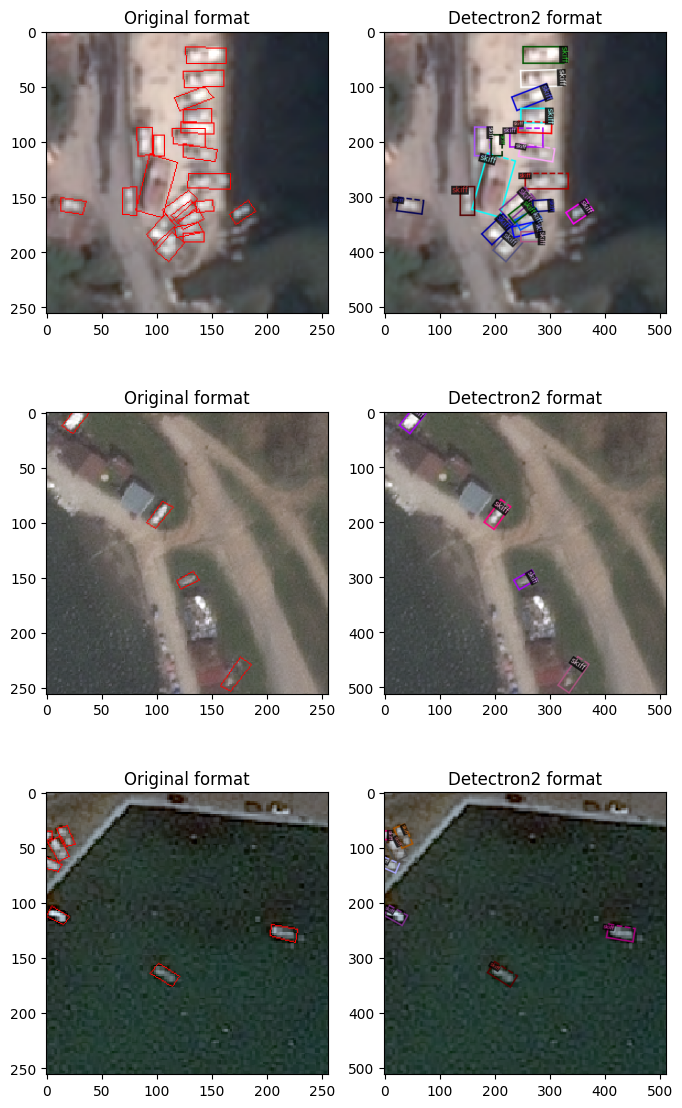

In [5]:
# select only images with ships from the training dataset
train_ship_images = [train_images[i] for i in np.where(y_train==1)[0]]

# list of images to be displayed
images_to_be_displayed = [train_ship_images[110], train_ship_images[12], train_ship_images[348]]

# set up sublots 
plt.subplots(len(images_to_be_displayed), 2, figsize=(8, len(images_to_be_displayed) * 4 + 2))

# display each image
for i, filename in enumerate(images_to_be_displayed):
    
    # get the bounding boxes from the original dataset
    bounding_boxes = get_bounding_boxes(filename)
    
    # open the image
    img = Image.open(satcen_path/'pictures'/filename)
    
    # draw each bounding box
    draw = Drawer.Draw(img)
    for bb in bounding_boxes:

        # convert coordinates to required format
        coords = [(c['x'], c['y']) for c in bb]

        # draw polygon
        draw.polygon(coords, outline=(255,0,0))

    # display the image using original format
    plt.subplot(len(images_to_be_displayed), 2, 2*i+1)
    plt.title('Original format')
    plt.imshow(img)

    # filter the dataset (list of dicts)
    filtered_dict = list(filter(lambda x: x['file_name'] == satcen_path/'pictures'/filename, train_dataset))
    if len(filtered_dict) == 0: 
        raise f'Could not find corresponding file in detectron2 dataset: {filename}'
    entry = filtered_dict[0]

    # draw bounding boxes on image
    img = cv2.imread(str(entry['file_name']))
    visualizer = Visualizer(img[:, :, ::-1], train_medatadata, scale=2)
    out = visualizer.draw_dataset_dict(entry)

    # display the image using detectron2 format
    plt.subplot(len(images_to_be_displayed), 2, 2*i+2)
    plt.title('Detectron2 format')
    plt.imshow(out.get_image())

plt.show()


# Training

## Construct the Model

### Define the Model Architecture

In [6]:
# get config
cfg = get_cfg()

# get base model
cfg.merge_from_file(model_zoo.get_config_file('COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml'))

# get the pre-trained weights
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url('COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml')

# set the train and test (validation) datasets
cfg.DATASETS.TRAIN = ('satcen_train',)
cfg.DATASETS.TEST = ('satcen_valid',)

# set the number of classes to be predicted
# we only have 1 class (skiff)
# background is not considered as class
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

# use RRPN as the proposal generator
cfg.MODEL.PROPOSAL_GENERATOR.NAME = 'RRPN'

# ROI head
cfg.MODEL.ROI_HEADS.NAME = 'RROIHeads'
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128 # number of ROIs samples from each image

# Box head
cfg.MODEL.ROI_BOX_HEAD.POOLER_TYPE = 'ROIAlignRotated'
cfg.MODEL.ROI_BOX_HEAD.BBOX_REG_WEIGHTS = (1,1,1,1,1)

# set the bbox regression weights of the RPN
cfg.MODEL.RPN.BBOX_REG_WEIGHTS = (1,1,1,1,1)

# Anchor generator
cfg.MODEL.ANCHOR_GENERATOR.NAME = 'RotatedAnchorGenerator'
cfg.MODEL.ANCHOR_GENERATOR.ANGLES = [[-90,-60,-30,0,30,60,90]]
cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[32, 64, 128, 256, 512]]

# specify where to save the model
cfg.OUTPUT_DIR = './models/faster_rcnn_rrpn'

## Methodology

In [7]:
# do not use images without skiffs in training
cfg.DATALOADER.FILTER_EMPTY_ANNOTATIONS = True

# number of ROIs sampled from each image during training
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512

# number of images per batch/iteration (actual batch size)
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.01  # pick a good LR
cfg.SOLVER.MAX_ITER = 25000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate

# build a custom mapper for the dataloader
def mapper(dataset_dict):
    
    # read image
    image = utils.read_image(dataset_dict['file_name'], format='BGR').copy()
    
    # convert to format (C, H, W)
    image = torch.from_numpy(image.transpose(2,0,1))

    # convert annotations to rotated instances
    instances = utils.annotations_to_instances_rotated(dataset_dict['annotations'], image.shape[1:])

    # return model input
    return {
        'image': image,
        'height': dataset_dict['height'],
        'width': dataset_dict['width'],
        'image_id': dataset_dict['image_id'],
        'filename': dataset_dict['file_name'],
        'instances': instances
    }  

cfg.DATALOADER.ASPECT_RATIO_GROUPING = False

# get the training dataloader
dataloader = build_detection_train_loader(cfg, mapper=mapper)

In [8]:
class CustomTrainer(DefaultTrainer):

    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=mapper)


# train model
# trainer = CustomTrainer(cfg)
# trainer.resume_or_load()
# trainer.train()

# # save model
# checkpointer = DetectionCheckpointer(model, save_dir='./models/faster_rcnn_rrpn')
# checkpointer.save('250iter_4bs')

# Evaluation

## Load the Model

Load the model trained using fixed lr.

In [9]:
# set the test score thresh
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.05
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.5

model = build_model(cfg)
DetectionCheckpointer(model).load('./models/faster_rcnn_rrpn/model_final.pth')

{'trainer': {'iteration': 24999,
  'hooks': {'LRScheduler': {'base_lrs': [0.01], 'last_epoch': 25000}},
  '_trainer': {'iteration': 24999,
   'optimizer': {'state': {0: {'momentum_buffer': tensor([[[[ 7.2324e-04]],
      
               [[-1.9934e-04]],
      
               [[-4.6507e-03]],
      
               ...,
      
               [[-4.2234e-03]],
      
               [[-1.8564e-03]],
      
               [[ 1.3391e-03]]],
      
      
              [[[-9.4458e-04]],
      
               [[ 2.2489e-04]],
      
               [[ 9.1606e-04]],
      
               ...,
      
               [[ 5.6416e-03]],
      
               [[ 2.1139e-03]],
      
               [[ 9.4681e-04]]],
      
      
              [[[-1.6008e-03]],
      
               [[-8.3258e-04]],
      
               [[-9.1859e-04]],
      
               ...,
      
               [[ 5.5686e-04]],
      
               [[-1.7198e-03]],
      
               [[-1.6375e-03]]],
      
      
          

## Qualitative Analysis 

Show ground truth vs. prediction for images with skiffs from the validation dataset.

/home/tudor/satcen-ship-detection/detectron2_env/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3488.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


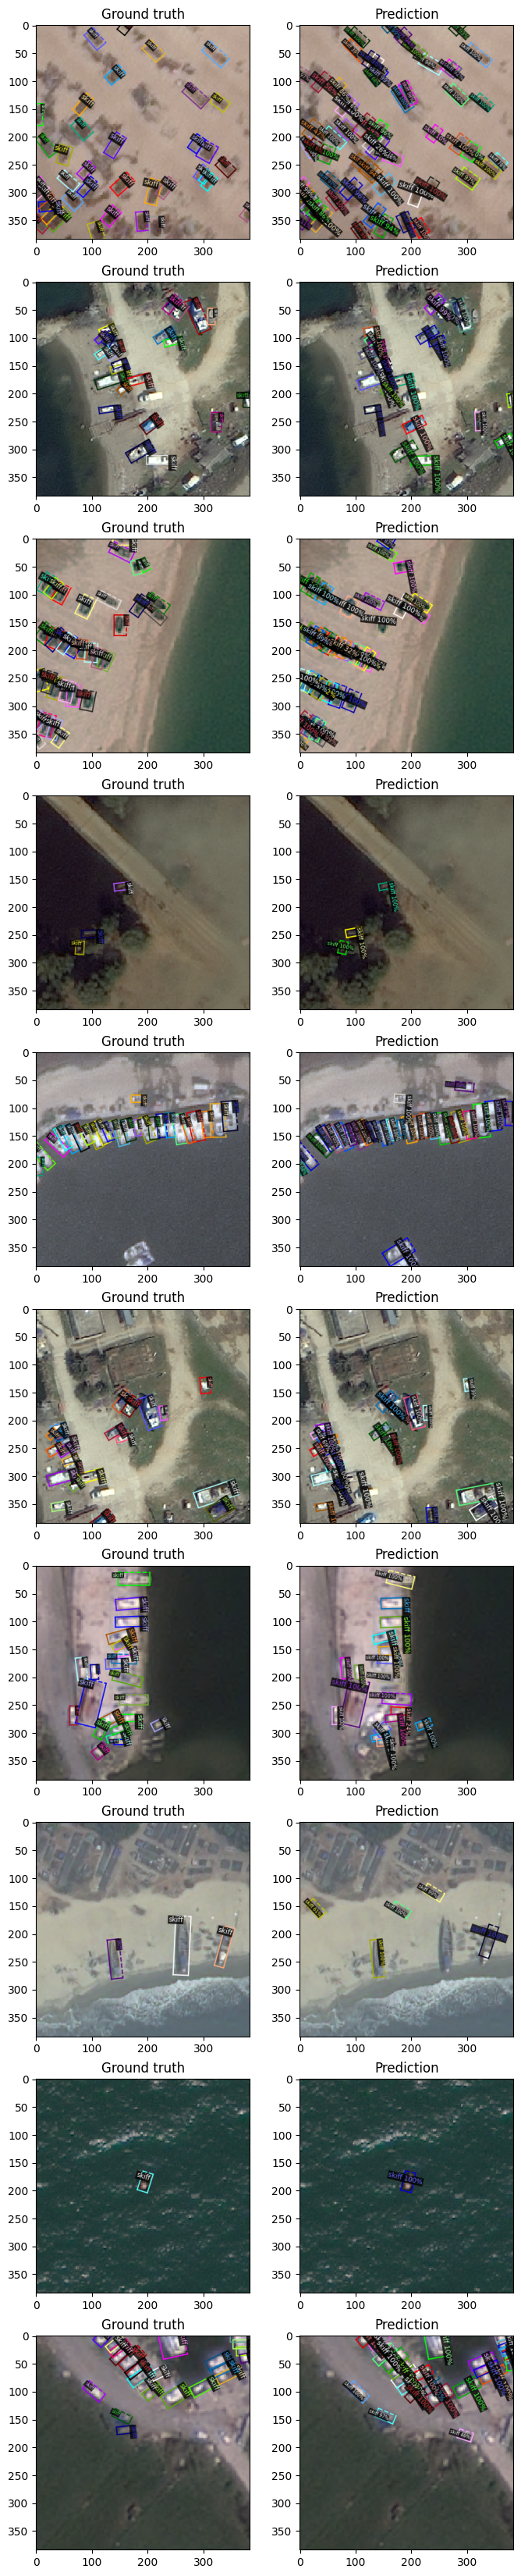

In [10]:
def convert_bb_to_detectron2(filename):
    """
        Converts the bounding boxes of an image to Detectron2 annotation format

        Arguments
        ---------
        filename: str
            image for which to convert bounding boxes to Detectron2 format (should not be the full path)
        
        Returns
        -------
        detectron2_dict: dict
            dict in detectron2 format
    """

    # list of annotations for the current image
    annotations = []

    # get the bounding boxes of the image
    bounding_boxes = get_bounding_boxes(filename)

    # loop through the bounding boxes
    for bb in bounding_boxes:
            
        # convert coordinates to required format
        points = np.array([[p['x'], p['y']] for p in bb])

        # get rotated rectangle
        ((cx, cy), (w, h), a) = cv2.minAreaRect(points)

        # store the annotation
        annotations.append({
            'bbox_mode': BoxMode.XYWHA_ABS,
            'bbox': (cx, cy, w, h, -a),
            'category_id': 0 # skiff
        })
        
    # store the image in the dataset
    return {
        'file_name': satcen_path/'pictures'/filename,
        'height': 256,
        'width': 256,
        'image_id': i,
        'annotations': annotations
    }
    
def inference(image_path, model):
    """
        Performs inference for one image

        Arguments
        ---------
        image_path: str, PosixPath
            full path to the image for which to perform inference
        model: torch.nn.Module
            model with which to perform inference

        Returns
        -------
        output: dict
            model output
    """

    # read the image in BGR format 
    image = utils.read_image(image_path, format='BGR').copy()
    
    # convert to format (C, H, W)
    image = torch.from_numpy(image.transpose(2,0,1))

    # put the model in inference mode
    model.eval()

    # perform inference
    with torch.no_grad():

        # perform inference
        input = {
            'image': image
        }
        output = model([input])[0]
 
        return output 

def show_gt_vs_pred(filenames, model):
    """
        Display ground truth and prediction side by side

        Arguments
        ---------
        filenames: list[str]
            list of image filenames for which to display gt vs prediction
        model: torch.nn.Module
            model to perform inference with
    """

    # get the metadata
    metadata = MetadataCatalog.get('satcen_train')

    # set up subplots
    plt.subplots(len(filenames), 2, figsize=(8, len(filenames) * 4 + 2))

    # loop through all the images
    for i, fn in enumerate(filenames):

        # get dataset dict in detectron2 format
        image_dict = convert_bb_to_detectron2(fn)

        # read the image
        image_full_path = image_dict['file_name']
        image = Image.open(image_full_path)

        # draw gt
        gt_vis = Visualizer(image, metadata=metadata, scale=1.5)
        gt_out = gt_vis.draw_dataset_dict(image_dict)

        # display gt
        plt.subplot(len(filenames), 2, 2*i + 1)
        plt.title('Ground truth')
        plt.imshow(gt_out.get_image())

        # perform inference on the image
        model_output = inference(image_full_path, model)
        
        # draw prediction instances
        pred_vis = Visualizer(image, metadata=metadata, scale=1.5)
        pred_out = pred_vis.draw_instance_predictions(model_output['instances'].to('cpu'))

        # display instance predictions
        plt.subplot(len(filenames), 2, 2*i + 2)
        plt.title('Prediction')
        plt.imshow(pred_out.get_image())

    plt.show()

# get validation images with skiffs
valid_images_skiffs = list(np.array(valid_images)[y_valid==1])

# randomly select images
images_to_check = random.sample(valid_images_skiffs, k=10)

# display gt vs prediction
show_gt_vs_pred(images_to_check, model)
    

Model has a hard time recognizing bigger skiffs with more detail? Look at this image **363-0-0.png**

Model is very sensitive, catches all skiffs but also predicts where there's nothing there. Calculate the number of validation images *without skiffs* for which something is predicted.

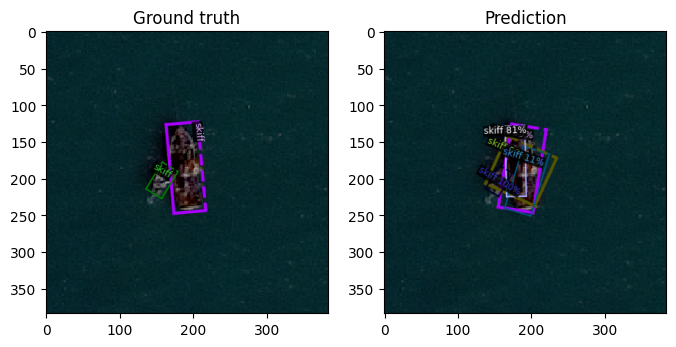

In [11]:
show_gt_vs_pred(['363-0-0.png'], model)

In [12]:
%load_ext tensorboard

## Binary Classifier

Evaluate the Rotated Faster R-CNN model as for binary classification. If the model detects at least 1 skiff in an image, it is considered a positive prediction. Otherwise, it is a negative prediction.

In [13]:
# binary predictions
y_valid_pred = []

# loop through all validation images
for i, valid_fn in enumerate(valid_images):

    # perform inference on the image
    output = inference(satcen_path/'pictures'/valid_fn, model)
    
    # positive prediction
    if len(output['instances']) > 0:
        y_valid_pred.append(1)
    else:
        y_valid_pred.append(0)

# convert to np array
y_valid_pred = np.array(y_valid_pred)

# calculate metrics
tp = np.sum((y_valid_pred==1)*(y_valid==1))
fp = np.sum((y_valid_pred==1)*(y_valid==0))
tn = np.sum((y_valid_pred==0)*(y_valid==0))
fn = np.sum((y_valid_pred==0)*(y_valid==1))

tpr = tp / np.sum(y_valid==1)
fpr = fp / np.sum(y_valid==0)
precision = tp / (tp + fp)

# print metrics
print(f'TP: {tp}')
print(f'FP: {fp}')
print(f'TN: {tn}')
print(f'FN: {fn}')
print()
print(f'Positive predictions: {np.sum(y_valid_pred==1)}')
print(f'Negative predictions: {np.sum(y_valid_pred==0)}')
print()
print(f'TPR: {tpr}')
print(f'FPR: {fpr}')
print(f'Precision: {precision}')

TP: 305
FP: 1576
TN: 3
FN: 0

Positive predictions: 1881
Negative predictions: 3

TPR: 1.0
FPR: 0.9981000633312223
Precision: 0.1621477937267411


## Object Detection Evaluation

Plot PR and ROC curves for object detection.

### Dataloader

Build a dataloader containing all validation images.

In [14]:
# get the validation dataloader
valid_dataloader = build_detection_test_loader(cfg, 'satcen_valid', mapper=mapper, batch_size=4)

In [15]:
# fn_test = list(set(valid_images) - set(valid_images_skiffs))[0]
# show_gt_vs_pred([fn_test], model)

# for b in valid_dataloader:
#     for inp in b:

#         if fn_test in str(inp['filename']):

#             gt_boxes_test = inp['instances'].gt_boxes
            
#             with torch.no_grad():
#                 opt = model([inp])[0]
#                 pred_boxes_test = opt['instances'].pred_boxes.to('cpu')
#                 scores_test = opt['instances'].scores

#                 print(pred_boxes_test)

#                 ious_test = pairwise_iou_rotated(pred_boxes_test, gt_boxes_test)
#                 for d in ious_test:
#                     if torch.all(d < 0.5):
#                         print('false')
#                     else:
#                         print('true')

### Inference

Perform inference on the validation images and store the detected objects in a dict for easier future use. The keys in the dict are image filenames (not full path) and the values are *Instances* objects.

In [53]:
detections = {}

# loop through validation batches
for batch in valid_dataloader:

    # perform inference on the batch
    with torch.no_grad():

        batch_outputs = model(batch)

        # store gt boxes in a dict
        for input, output in zip(batch, batch_outputs):
            
            # extract image filename
            img_fn = str(input['filename']).split('/')[-1]

            detections[img_fn] = output['instances'].to('cpu')


### Predictions Table

1. Generate predictions for the validation images.
2. Aggregate predictions in a table.
3. Sort table in descending order of confidence scores.
4. Compute precisions and recalls.

The entries in the table are the model's individual detections on the validation images. The table has the following columns (in this order):
- confidence score
- correct (*True* if TP, *False* if FP)
- cumulative TP 
- cumulative FP
- precision
- recall

The last 4 columns are calculated with respect to all detections up to (and including) the current row in descending order.

To determine if a detection is a TP or a FP:
1. If the IOU between the detection box and *all* ground truth boxes is less than the specified threshold, mark the detection as FP
2. If the IOU between the detection box and *any* ground truth box is greater than or equal to the specified threshold:
    - If there are multiple detections with IOUs greater than or equal to the specified threshold, mark the detection with the highest confidence score as TP and the rest as FP.

In [47]:
def precision_recall_curve(iou_thresh, detections, no_gt_boxes):
    """
    Calculates precision and recall curve for a given IOU threshold

    Arguments
    ---------
    iou_thresh : float
        IOU threshold
    detections : dict
        Dictionary with image filenames as keys and instances objects (detections) as values 
    no_gt_boxes : int
        Number of ground truth boxes in the set of images to plot PR curve for. Needed for recall calculation

    Returns
    -------
    (precisions, recalls) : tup(ndarray)
        Precision and recall values
    """

    predictions_table = {
        'score': [],
        'correct': [],
        'cum_tp': [],
        'cum_fp': [],
        'precision': [],
        'recall': []
    }

    # loop through the images in the evaluation set
    for img_fn in detections.keys():

        # get the gt boxes
        gt_boxes = mapper(convert_bb_to_detectron2(img_fn))['instances'].gt_boxes

        # get the predicted boxes
        pred_boxes = detections[img_fn].pred_boxes

        # get the confidence scores
        scores = detections[img_fn].scores

        # compute IOUs between gt and pred boxes
        # rows -> pred boxes
        # columns -> gt boxes
        ious = pairwise_iou_rotated(pred_boxes, gt_boxes)

        # loop through the detections
        for detection_ious, confidence_score in zip(ious, scores):
                
            if torch.all(detection_ious < iou_thresh): # all IOUs less than threshold
                correct = False
            else: # some IOUs greater than threshold
                    
                # get the index of the gt box for which the IOU is >= threshold
                gt_box_idx = torch.where(detection_ious >= iou_thresh)[0][0].item()

                # get the indices of the detections with IOUs >= threshold for this gt box
                candidate_preds = torch.where(ious[:, gt_box_idx] >= iou_thresh)[0]

                # get the maximum confidence score for the candidate predictions
                max_conf_score = torch.max(scores[candidate_preds])

                # check if the current prediction has the highest confidence score
                # out of all candidate predictions
                if confidence_score == max_conf_score:
                    correct = True
                else:
                    correct = False

            # store results in dict
            predictions_table['score'].append(confidence_score.item())
            predictions_table['correct'].append(correct)
            predictions_table['cum_tp'].append(-1)
            predictions_table['cum_fp'].append(-1)
            predictions_table['precision'].append(-1)
            predictions_table['recall'].append(-1)
                
    # convert dict to df
    predictions_table = pd.DataFrame(predictions_table)

    # sort df in descending order of confidence score
    predictions_table.sort_values(by='score', ascending=False, inplace=True, ignore_index=True)

    # update values for first row
    predictions_table.loc[0, 'cum_tp'] = 1 if predictions_table.loc[0]['correct'] else 0
    predictions_table.loc[0, 'cum_fp'] = 1 if not predictions_table.loc[0]['correct'] else 0
    predictions_table.loc[0, 'precision'] = predictions_table.loc[0]['cum_tp']
    predictions_table.loc[0, 'recall'] = predictions_table.loc[0]['cum_tp'] / no_gt_boxes

    # loop through all df rows
    for index in range(1, len(predictions_table)):
        
        # update values
        predictions_table.loc[index, 'cum_tp'] = predictions_table.loc[index - 1, 'cum_tp'] + (1 if predictions_table.loc[index]['correct'] else 0)
        predictions_table.loc[index, 'cum_fp'] = predictions_table.loc[index - 1, 'cum_fp'] + (1 if not predictions_table.loc[index]['correct'] else 0)
        predictions_table.loc[index, 'precision'] = predictions_table.loc[index]['cum_tp'] / (index + 1)
        predictions_table.loc[index, 'recall'] = predictions_table.loc[index]['cum_tp'] / no_gt_boxes

    # get precision and recall values
    precisions = predictions_table['precision'].to_numpy()
    recalls = predictions_table['recall'].to_numpy()

    return precisions, recalls

### Validation PR Curves

Plot PR curve for the **validation set** and calculate average precision values for different IOU thresholds.

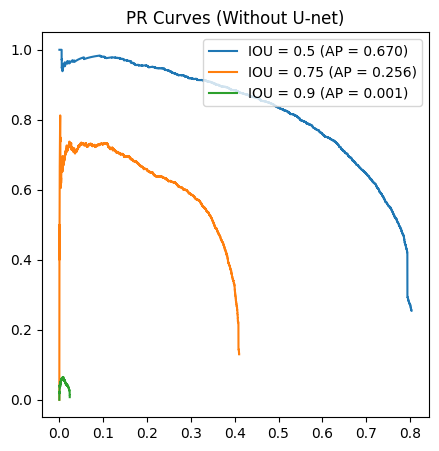

In [60]:
plt.figure(figsize=(5,5))
plt.title('PR Curves (Without U-net)')

# calculate total number of gt boxes
no_gt_boxes = 0
for img_fn in valid_images:
    no_gt_boxes += len(get_bounding_boxes(img_fn))

# define thresholds
iou_thresholds = [0.5, 0.75, 0.9]

# loop through thresholds
for t in iou_thresholds:
    
    # compute precisions and recalls for current thresholds
    precisions, recalls = precision_recall_curve(t, detections, no_gt_boxes)

    # compute AP
    ap = auc(recalls, precisions)

    # plot curve
    plt.plot(recalls, precisions, label=f'IOU = {t} (AP = {ap:.3f})')

plt.legend(loc='upper right')
plt.show()

## Pipeline Testing

Test the whole U-net + Rotated Faster R-CNN pipeline:
1. Use U-net to separate images that contain skiffs (positive predictions) from images that do not contain skiffs (negative predictions)
2. Use Rotated Faster R-CNN to detect skiffs in images predicted (by U-net) to have skiffs.

### Inference

Load the list of U-net's positive predictions and perform inference on them using Rotated Faster R-CNN.

In [19]:
# load U-net positive predictions
valid_images_pos_pred = np.load('pipeline/unet_positive_predictions.npy')
print(f'Number of U-net positive predictions: {len(valid_images_pos_pred)}')

Number of U-net positive predictions: 322


In [27]:
# store detections in a dict
# keys -> image filename (not full path)
# values -> instances objects
pipeline_detections = {}

for img_fn in valid_images_pos_pred:

    # perform inference
    output = inference(satcen_path/'pictures'/img_fn, model)

    # save detections
    pipeline_detections[img_fn] = output['instances']

### Pipeline PR Curve

Plot PR curve for the pipeline